# Gatys Neural Style Transfer

Import the modules we need.

In [71]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
from matplotlib import image
import glob as glob
from PIL import Image

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  2.2.0+cu118
Torchvision Version:  0.17.0+cu118
Using the GPU!


## Step 0: Downloading the dataset and backbone network.
For this problem, we will use five images as our artistic style, and the Coco validation set as our content image.

A pretrained VGG 19 will be applied to extract features.

In [72]:
# Download the VGG19 model
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return out

cnn = VGG(pool='avg').eval().to('cuda')
cnn.load_state_dict(torch.load('./Models/vgg_conv.pth'))

# Freeze the parameters as there's no need to train the net. Ignore the warnings.
for param in cnn.parameters():
    param.requires_grad = False

## STEP 1: Create the image loader and some utility funtions
Provide the dataloader for images and a function to get the list of feature maps from a forward pass in the network.

In [73]:
# Dataloader
imsize = 224

VGG19_MEAN = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float)
VGG19_STD = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float)


def image_loader(image_name, imsize):
    image = Image.open(image_name)
    transform = transforms.Compose([
        transforms.Resize(imsize),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=VGG19_MEAN.tolist(),
            std=VGG19_STD.tolist(),
        ),
        transforms.Lambda(lambda x: x.mul(255)),
        # It seems that the torchvision's VGG19 implementation is expecting the input to be in the 0-255 range, instead of 0-1
    ])
    image = transform(image)
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image.to(device, torch.float)

# visualizing the content and style images

style_img = image_loader("./Images/mona.jpg", imsize)
content_img = image_loader("./Images/anni.jpg", imsize)

print(style_img.shape)
print(content_img.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


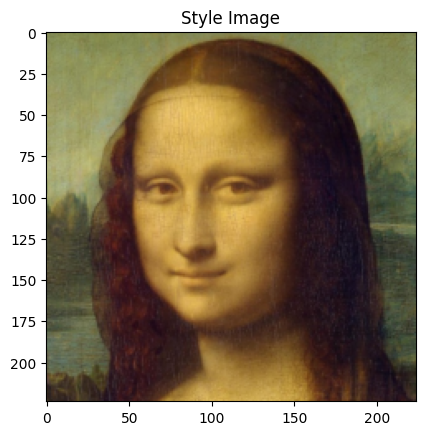

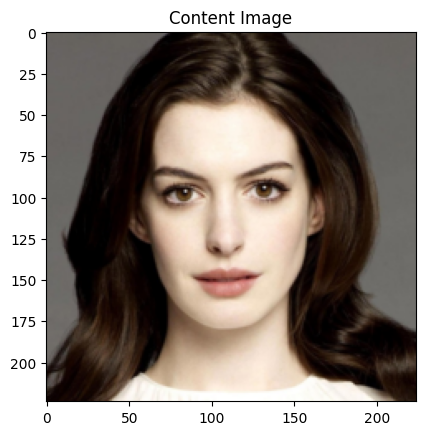

In [74]:
deprocess = transforms.Compose([
    transforms.Lambda(lambda x: x.mul(1/255)),
    transforms.Normalize(
        (0, 0, 0),
        (1.0 / VGG19_STD).tolist(),
    ),
    transforms.Normalize(
        (-VGG19_MEAN).tolist(),
        (1, 1, 1),
    ),
    transforms.Lambda(lambda x: x.clamp(0, 1)),
    transforms.ToPILImage(),
])

plt.ion()

def imshow(im_tensor, title=None):
    image = im_tensor.cpu().clone()    
    image = deprocess(image[0])
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

Some utility functions

In [75]:
def get_feature_maps(x, cnn):
    """
    Get the list of feature maps in a forward pass.
    
    Inputs:
    - x: A batch of images with shape (B, C, H, W)
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of features for the input images x extracted using the cnn model.
      features[i] is a Tensor of shape (B, C_i, H_i, W_i).
    """
    feats = cnn(x)
    return feats

## Step 2: Implementing content loss
Firstly, we will implement the content loss. This loss encourages the generated image to match the scene structure of the content image. We will implement this loss as the squared $\ell_2$ distance between two convolutional feature maps. Given a feature map of input image $F^x$ and the feature map of content image $F^{c}$, both of shape $(C, H, W)$, the content loss is calculated as follows:

\begin{equation}
\mathcal{L}_c = \sum_{c,i,j}(F^{c}_{c, i, j} - F^{x}_{c, i, j}) ^ 2. 
\end{equation}

In [76]:
def content_loss(f_x, f_con):
    """
    Compute the content loss.
    
    Inputs:
    - f_x: features of the input image with tensor size (1, C, H, W).
    - f_con: features of the content image with tensor size (1, C, H, W).
    Returns:
    - lc: the content loss
    """
    lc = F.mse_loss(f_x, f_con, reduction='sum')
    return lc

## Step 3: Implementing style loss
Next, we will implement the style loss. This loss encourages the texture of the resulting image to match the input style image. We compute a weighted, squared $\ell_2$ distance between Gram matrices for several layers of the network.

The first step is to calculate the Gram matrix. Given a feature map $F$ of size $(C, H, W)$, the Gram matrix $G \in \mathbb{R}^{C \times C}$ computes the sum of products between channels. The entries $k, l$ of the matrix are computed as:
\begin{equation}
G_{k,l} = \sum_{i,j} F_{k,i,j} F_{l,i,j}.
\end{equation}

The second step is to compare the generated image's Gram matrix with that of the input style image. Define the Gram matrix of input image feature map and style image feature map of at the $l^{th}$ layer as $G^{x,l}$ and $G^{s, l}$, and the weight of the layer as $w^l$. Style loss at the $l^{th}$ layer is
\begin{equation}
L_s^l = w^l \sum_{i,j} (G^{x,l}_{i,j} - G^{s, l}_{i,j})^2,
\end{equation}
where $w^l$ is the weight of layer $l$. The total style loss is a sum over all style layers:
\begin{equation}
    \mathcal{L}_s = \sum_l L_s^l.
\end{equation}

In [77]:
def gram_matrix(feat, normalize=True):
    """
    Compute the gram matrix.
    
    Inputs:
    - feat: a feature tensor of shape (1, C, H, W).
    - normalize: if normalize is true, divide the gram matrix by C*H*W:
    Returns
    - gram: the tram matrix
    """
    feat = feat.squeeze(0)

    # Use the einsum method to compute vector dot product in high dimension
    gram = torch.einsum("kij,lij->kl", feat, feat)

    # Normalize the gram matrix
    if normalize:
        gram = gram/(feat.shape[0]*feat.shape[1]*feat.shape[2])

    return gram

In [78]:
def style_loss(feats, style_layers, style_targets):
    """
    Computes the style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function. The list will contain the features of all layers 
      instead of the layers for calcculating style loss
    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a PyTorch Tensor giving the Gram matrix of the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
      
    Returns:
    - loss: A PyTorch Tensor holding a scalar giving the style loss.
    """
    loss = 0.0

    for i in range(len(style_layers)):
      # Compute the Gram matrix of the input feature map from the specified layer
      input_feature_img = feats[style_layers[i]]
      input_gram = gram_matrix(input_feature_img)

      # Compute the loss
      loss += F.mse_loss(input_gram, style_targets[i], reduction='sum')

    return loss

## Step 4: Implementing Laplacian loss
At last, we will implementa Laplacian loss into neural style transfer, to steer the stylised image towards having a similar Laplacian to that of the content image. The Laplacian loss is defined as the mean-squared distance between the two Laplacians.

The Laplacian loss is computed by a small two-layer fixed CNN which includes an average pooling layer and a perspecified convolutional layer. The former layer smoothes the input image which can make the Laplacian loss better reflect its true detail strcutures. The latter layer combines a Laplacian operator to detect the edges of the content image.

In addition, we compute the Laplacian of an image on RGB channels, which means the Laplacian value consists of the three Laplacians:
\begin{equation}
D(x) = D(x^R) + D(x^G) + D(x^B).
\end{equation}
Finally, given the content image and the stylised image, we can compute the Laplacian loss to measure the difference between their Laplacians:
\begin{equation}
L_{Lap} = \sum_{i,j} (D(x_{c}) - D(x))_{i,j}^2.
\end{equation}

In [79]:
"""
Define a 2-layer neural network to process the content image and the stylised image
An average pooling layer and a Laplacian convolutional layer
"""
class LaplacianNet(nn.Module):
  def __init__(self):
    super(LaplacianNet, self).__init__()
    """
    The LaplacianNet consists of an average pooling layer and a Laplacian conv layer.
    """
    self.avgpooling = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 1)
    self.laplacian = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = (3, 3), stride = 1, padding = 1)
    self.laplacian.weight.data = torch.tensor([[[[0, -1, 0],
                          [-1, 4, -1],
                          [0, -1, 0]]]]).float().to(device) # Attention: weight should be float() !!!
  def forward(self, image):
    """
    Args:
    image: torch tensor, shape of (1, C, H, W) ---- RGB three channels input
    # image: torch tensor, shape of (1, 1, H, W) ---- RGB one channels input
    return:
    Laplacian_value: float, sum of the values of the three RGB Laplacians of the image
    """
    # Perform average pooling
    image_pooling = self.avgpooling(image).to(device)
    # Perform RGB Laplacian
    Channels = image.shape[1]
    image_laplacian = torch.zeros((1, 1, image_pooling.shape[2], image_pooling.shape[3])).to(device)

    # RGB three channels
    for i in range(Channels):
      image_laplacian_RGB = self.laplacian(image_pooling[:,i:i+1,:,:])
      image_laplacian += image_laplacian_RGB
    # print("before resize image_laplacian.shape: ", image_laplacian.shape)
    image_laplacian = image_laplacian.resize(image_laplacian.shape[2], image_laplacian.shape[3]).to(device)
    # print("after resize image_laplacian.shape: ", image_laplacian.shape)

    # RGB one channel
    # image_laplacian = self.laplacian(image_pooling)

    return image_laplacian

In [80]:
# Intialize a LaplacianNet
LaplacianNetwork = LaplacianNet().to(device)
def laplacian_loss(content_img, stylised_img):
    """
    Compute the laplacian loss.
    
    Inputs:
    - content_img: the content image with tensor size (1, C, H, W).
    - stylised_img: the stylised image with tensor size (1, C, H, W).
    Returns:
    - llap: the laplacian loss
    """
    
    # Compute the Laplacian summation of content img and stylised img through the LaplacianNet
    Laplacian_content = LaplacianNetwork(content_img)
    Laplacian_stylised = LaplacianNetwork(stylised_img)

    # Compute the Laplacian loss
    llap = 0.0
    Laplacian_diff = Laplacian_content - Laplacian_stylised
    llap = torch.sum(Laplacian_diff**2)

    return llap

## Step 5: Network Training
Test out the style transfer!

In [87]:
params1 = {
    # VGG19 params:
    'content_image':'./Images/anni.jpg', # Change the directory to the content image you want!!
    'style_image':'./Images/ava.jpg', # Change the directory to the style image you want!!
    'image_size':512,
    'style_size':512,
    'content_layer':'r41', # conv4-1
    'content_weight':1,
    'depth_weight':1e3, # finetune
    'style_layers':['r11', 'r21', 'r31', 'r41', 'r51'], # con 1-1, conv2-1, conv3-1, conv4-1, conv5-1
    'style_weights':1e2,
    'laplacian_weight':0, # finetune
    'init_random':True,
}

Extract features for the content image

content_target.shape:  torch.Size([1, 512, 64, 64])


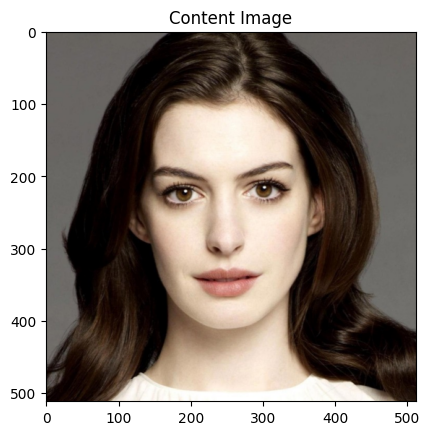

In [88]:
content_image = params1['content_image']
image_size = params1['image_size']
content_layer = params1['content_layer']

content_img = image_loader(content_image, image_size)
# print("content_img.shape: ", content_img.shape) # [1, 3, 192, 287]
feats = get_feature_maps(content_img, cnn)
content_target = feats[content_layer].clone()

print("content_target.shape: ", content_target.shape)

# Show the content image
plt.figure()
imshow(content_img, title='Content Image')

Extract features for the style image

torch.Size([64, 64])


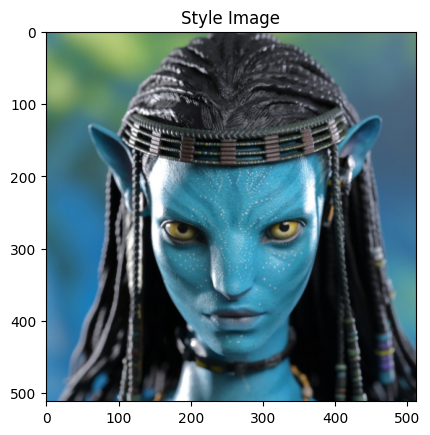

In [89]:
style_image = params1['style_image']
style_size = params1['style_size']
style_layers = params1['style_layers']

style_img = image_loader(style_image, style_size)
feats = get_feature_maps(style_img, cnn)
style_targets = []

for idx in style_layers:
    style_targets.append(gram_matrix(feats[idx].clone()))

print(style_targets[0].shape)

# Show the style image
plt.figure()
imshow(style_img, title='Style Image')

Initialize output image to content image or noise

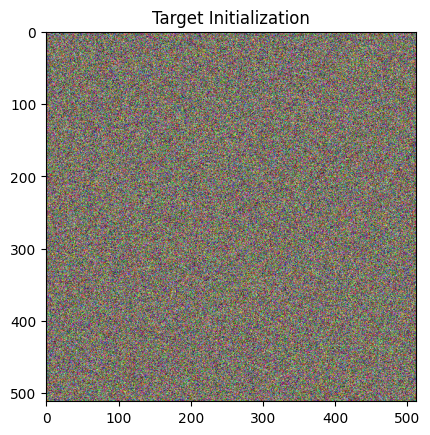

In [90]:
init_random = params1['init_random']

if init_random:
    img = torch.randn_like(content_img).to(device) * 255
else:
    img = image_loader(style_image, (content_img.shape[2], content_img.shape[3]))

plt.figure()
imshow(img.data, title='Target Initialization')

Setup.

In [91]:
# We do want the gradient computed on our image!
img.requires_grad_()

# Set up optimization
optimizer = optim.LBFGS([img])

Train.

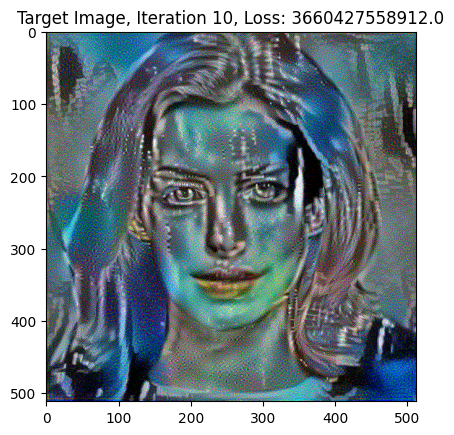

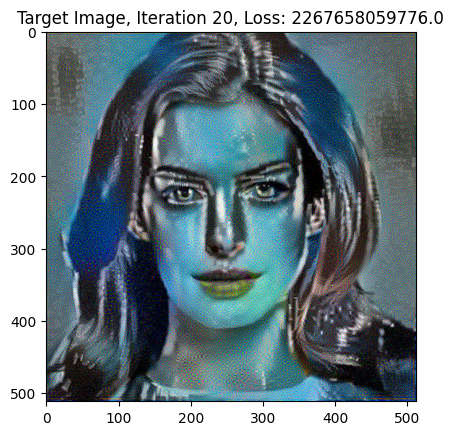

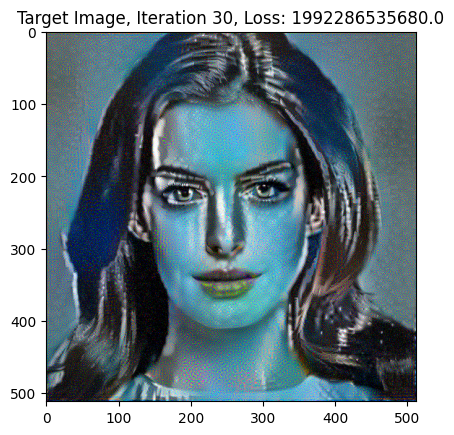

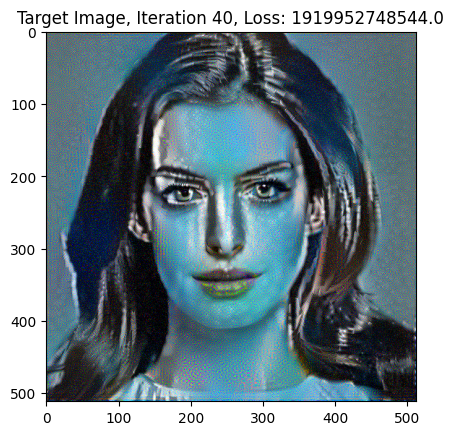

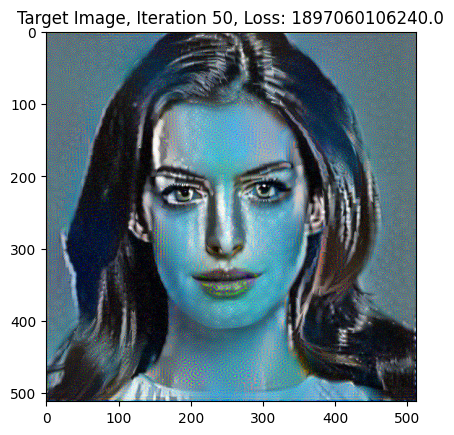

KeyboardInterrupt: 

In [92]:
iters = 300
show_every = 10
content_weight = params1['content_weight']
style_weight = params1['style_weights']
laplacian_weight = params1['laplacian_weight']

# Run the style transfer
for i in range(1, iters+1):
    def closure():
        optimizer.zero_grad()
        feats = get_feature_maps(img, cnn)
        L_content = content_loss(feats[content_layer], content_target)
        L_style = style_loss(feats, style_layers, style_targets)
        L_laplacian = laplacian_loss(content_img, img)
        loss = content_weight * L_content + style_weight * L_style + laplacian_weight * L_laplacian
        loss.backward()
        return loss

    optimizer.step(closure)

    if i % show_every == 0:
        loss = closure()
        plt.figure()
        imshow(img.data, title=f'Target Image, Iteration {i}, Loss: {loss.item()}')

# Save the final image
output_img = deprocess(img[0])
output_img.save(f'./results/output_{content_image.split("/")[-1]}_{style_image.split("/")[-1]}.jpg')